In [1]:
import numpy as np
from sklearn.manifold import Isomap

import matplotlib.pyplot as plt

import librosa
from librosa.core import amplitude_to_db

In [2]:
def isomapEmbedding(batch_features, q=24, comp='log', n_neighbors=3, n_octaves=3, n_dimensions=3):
    '''
    Returns an isomap embedding in n_dimensions, with n_neighbors neighborhood graph and
    restricted to n_octaves
    
    Inputs
    ------
    batch_features- np.ndarray of CQT features stacked horizontally
    q- frequency bins per octave used in CQT features
    comp- compression, 'log' by default
    n_neighbors- number of neighbors in k-nearest neighbor graph, 3 by default
    n_octaves- number of octaves in output embedding with range of relative importance is chosen, 3 by default
    n_dimensions- number of dimensions, 3 by default
    
    Returns
    ------
    isomap - Isomap object with learned embedding
    freqs - Frequency bin array
    rho_std - Pearson correlation matrix
    '''
    
    
    CQT_OCTAVES = 7
    
    if comp!='log':
        raise Exception("Only log compression currently supported")
    else:
        features = amplitude_to_db(batch_features)

    # Prune feature matrix
    bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
    bin_high = bin_low + n_octaves*q 
    X = features[bin_low:bin_high, :]

    # Z-score Standardization- improves contrast in correlation matrix
    mus = np.mean(X, axis=1)
    sigmas = np.std(X, axis=1)
    X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

    # Pearson correlation matrix
    rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]
    
    # Isomap embedding
    isomap = Isomap(n_components=n_dimensions, n_neighbors=n_neighbors)
    isomap.fit_transform(rho_std)
    
    # Get note value
    freqs = librosa.cqt_frequencies(q*CQT_OCTAVES, fmin=librosa.note_to_hz('C1'), bins_per_octave=q) #librosa CQT default fmin is C1
    chroma_list = librosa.core.hz_to_note(freqs[bin_low:bin_high])

    notes = []
    reps = q//12
    for chroma in chroma_list:
        for i in range(reps):
            notes.append(chroma)
            
    # Return embedding object
    return isomap, freqs, rho_std

In [3]:
import h5py
import os

data_dir = '/Users/sripathisridhar/Documents/GitHub/embedding-bio/'
with h5py.File(os.path.join(data_dir,"SOL.h5"), "r") as f:
    features_dict = {key:f[key][()] for key in f.keys()}

In [4]:
batch_features = []
q=24
for key in features_dict.keys():
    if 'Hp-ord' in key:
        batch_features.append(features_dict[key])
    
batch_features = np.stack(batch_features, axis=1)

isomap, freqs, rho_std = isomapEmbedding(batch_features)
coords = isomap.embedding_

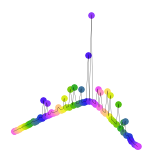

In [5]:
curr_fig = plt.figure(figsize=(5.5, 2.75))
ax = curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list = [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color=color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


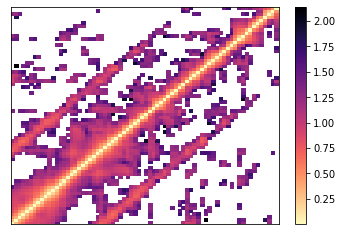

In [7]:
adj_mat = np.sqrt(-0.5 * np.log(rho_std))

from librosa import display
librosa.display.specshow(adj_mat, cmap='magma_r')
plt.colorbar()